In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime


from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
roc_curve, confusion_matrix, classification_report, precision_recall_curve)
from sklearn.inspection import permutation_importance
import joblib
import re
import os

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
df=pd.read_csv('archive/customer_churn_dataset-testing-master.csv')
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [6]:
df.shape

(64374, 12)

In [7]:
df.columns

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Churn'],
      dtype='object')

In [8]:
# Checking the Missing Values

df.isnull().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB


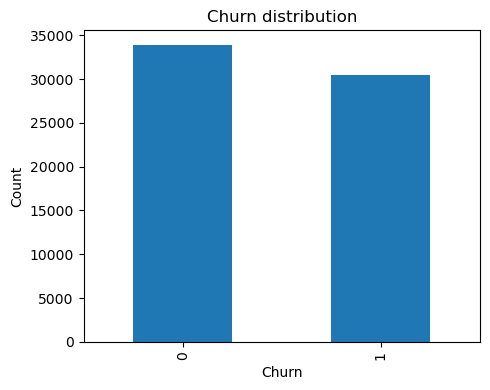

In [10]:
# Plot churn distribution
plt.figure(figsize=(5,4))
df['Churn'].value_counts().plot(kind='bar')
plt.title('Churn distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [11]:
# Changing columns name to smaller
df.columns=df.columns.str.replace(' ','_').str.lower()
df.columns

Index(['customerid', 'age', 'gender', 'tenure', 'usage_frequency',
       'support_calls', 'payment_delay', 'subscription_type',
       'contract_length', 'total_spend', 'last_interaction', 'churn'],
      dtype='object')

In [12]:
# Checking the Object column
df.select_dtypes(include='object').columns

Index(['gender', 'subscription_type', 'contract_length'], dtype='object')

In [13]:
print(df['gender'].unique())
print("------------------------")
print(df['subscription_type'].unique())
print("------------------------")
print(df['contract_length'].unique())
print("------------------------")

['Female' 'Male']
------------------------
['Basic' 'Standard' 'Premium']
------------------------
['Monthly' 'Annual' 'Quarterly']
------------------------


In [14]:
# Using Label Encoder on Gender       
# Female ------------------->  0
# Male ------------------->  1

le=LabelEncoder()
df['gender']=le.fit_transform(df['gender'])

In [15]:
# Using one hot encoder on rest

# Select columns
cols_to_encode = ['subscription_type', 'contract_length']

# Initialize and fit
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_array = ohe.fit_transform(df[cols_to_encode])

# Get new column names
encoded_cols = ohe.get_feature_names_out(cols_to_encode)

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index)

# Drop original columns & concat encoded ones
df = df.drop(columns=cols_to_encode)
df = pd.concat([df, encoded_df], axis=1)

In [16]:
df.head()

,customerid,age,gender,tenure,usage_frequency,support_calls,payment_delay,total_spend,last_interaction,churn,subscription_type_Basic,subscription_type_Premium,subscription_type_Standard,contract_length_Annual,contract_length_Monthly,contract_length_Quarterly
0,1,22,0,25,14,4,27,598,9,1,1.0,0.0,0.0,0.0,1.0,0.0
1,2,41,0,28,28,7,13,584,20,0,0.0,0.0,1.0,0.0,1.0,0.0
2,3,47,1,27,10,2,29,757,21,0,0.0,1.0,0.0,1.0,0.0,0.0
3,4,35,1,9,12,5,17,232,18,0,0.0,1.0,0.0,0.0,0.0,1.0
4,5,53,0,58,24,9,2,533,18,0,0.0,0.0,1.0,1.0,0.0,0.0


In [17]:
df.columns

Index(['customerid', 'age', 'gender', 'tenure', 'usage_frequency',
       'support_calls', 'payment_delay', 'total_spend', 'last_interaction',
       'churn', 'subscription_type_Basic', 'subscription_type_Premium',
       'subscription_type_Standard', 'contract_length_Annual',
       'contract_length_Monthly', 'contract_length_Quarterly'],
      dtype='object')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  64374 non-null  int64  
 1   age                         64374 non-null  int64  
 2   gender                      64374 non-null  int64  
 3   tenure                      64374 non-null  int64  
 4   usage_frequency             64374 non-null  int64  
 5   support_calls               64374 non-null  int64  
 6   payment_delay               64374 non-null  int64  
 7   total_spend                 64374 non-null  int64  
 8   last_interaction            64374 non-null  int64  
 9   churn                       64374 non-null  int64  
 10  subscription_type_Basic     64374 non-null  float64
 11  subscription_type_Premium   64374 non-null  float64
 12  subscription_type_Standard  64374 non-null  float64
 13  contract_length_Annual      643

In [19]:
# Split the Data

X=df.drop(df[['churn','customerid']],axis=1)
Y=df['churn']

In [20]:
print(X.shape,Y.shape)

(64374, 14) (64374,)


In [21]:
# Training

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(51499, 14) (51499,)
(12875, 14) (12875,)


In [22]:
# Defining the Models
models = {
    'logreg': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, solver='saga'),
    'rf': RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
    'gb': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'hgb': HistGradientBoostingClassifier(random_state=RANDOM_STATE)
}

In [23]:
# Cross-validate and compare
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_results = {}

for name, model in models.items():
    print(f"Training {name}...")
    scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    cv_results[name] = np.mean(scores)
    print(f"{name} Mean ROC AUC: {np.mean(scores):.4f}")

best_model_name = max(cv_results, key=cv_results.get)
print(f"\nBest model: {best_model_name}")

Training logreg...
logreg Mean ROC AUC: 0.8934
Training rf...
rf Mean ROC AUC: 1.0000
Training gb...
gb Mean ROC AUC: 0.9999
Training hgb...
hgb Mean ROC AUC: 1.0000

Best model: hgb


In [24]:
# Train best model on full training data
best_model = models[best_model_name]
best_model.fit(X_train, Y_train)

,loss,'log_loss'
,learning_rate,0.1
,max_iter,100
,max_leaf_nodes,31
,max_depth,None
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'
,monotonic_cst,None


In [25]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

In [26]:
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

print(f"Test ROC AUC: {roc_auc_score(Y_test, y_proba):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6793
           1       1.00      1.00      1.00      6082

    accuracy                           1.00     12875
   macro avg       1.00      1.00      1.00     12875
weighted avg       1.00      1.00      1.00     12875

Test ROC AUC: 1.0000


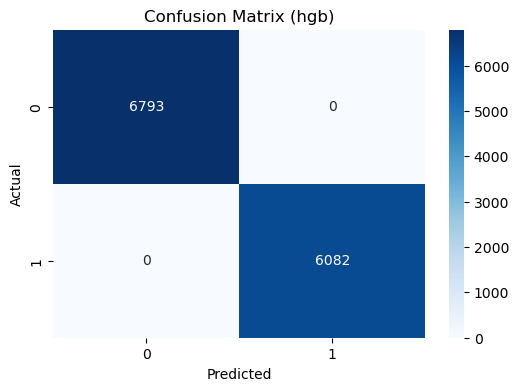

In [27]:
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix ({best_model_name})")
plt.show()

In [28]:
# Save the trained model
joblib.dump(best_model, "best_churn_model.joblib")
print(" Model  saved.")

 Model  saved.


In [29]:
# Making a Predictive System

import pandas as pd
import joblib

def predict_churn(new_data):
    # Load model
    model = joblib.load("best_churn_model.joblib")
    
    # Convert input to DataFrame (must have same columns as training X)
    new_df = pd.DataFrame([new_data])
    
    # Predict
    pred = model.predict(new_df)[0]
    proba = model.predict_proba(new_df)[0][1]
    
    return pred, proba

In [30]:
new_customer = {
    'age': 22,
    'gender': 0,  
    'tenure': 25,
    'usage_frequency': 14,
    'support_calls': 4,
    'payment_delay': 27,
    'total_spend': 598,
    'last_interaction': 9,
    'subscription_type_Basic': 1,
    'subscription_type_Premium': 0,
    'subscription_type_Standard': 0,
    'contract_length_Annual': 0,
    'contract_length_Monthly': 1,
    'contract_length_Quarterly': 0
}

pred, proba = predict_churn(new_customer)

print(f"Predicted Churn: {'Yes' if pred==1 else 'No'}")
print(f"Churn Probability: {proba:.2%}")

Predicted Churn: Yes
Churn Probability: 99.75%


In [55]:
new_customer = {
    'age': 30,
    'gender': 0,
    'tenure': 40,
    'usage_frequency': 19,
    'support_calls': 1,
    'payment_delay': 30,
    'total_spend': 650,
    'last_interaction': 18,
    'subscription_type_Basic': 0,
    'subscription_type_Premium': 0,
    'subscription_type_Standard': 0,
    'contract_length_Annual': 0,
    'contract_length_Monthly': 1,
    'contract_length_Quarterly': 0
}

pred, proba = predict_churn(new_customer)

print(f"Predicted Churn: {'Yes' if pred==1 else 'No'}")
print(f"Churn Probability: {proba:.2%}")

Predicted Churn: Yes
Churn Probability: 99.97%
